사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측
=========================================================

LinearRegression 클래스 - Ordinary Least Squares
--------------------------------------------------
LinearRegression 클래스 : 예측값과 실제 값의 RSS (Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares) 추정 방식으로 구현한 클래스


class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)


입력 파라미터
- fit_intercept : intercept값을 계산할지 말지를 지정
- normalize : True이면 회귀를 수행하기 전에 입력 데이터 세트를 정규화

속성
- coef_ : 회귀 계수가 배열 형태로...
- intercept_ : intercept 값

다중 공선성(multi-colinearity)문제 : 피처 간의 상관관계가 매우 높은 경우, 분산이 매우 커져서 오류에 민감해지는 현상
- 독립적인 중요한 피처만 남기고 제거하거나 규제 적용해서 문제 해결하기
- PCA 통해 차원 축소해서 문제 해결하기

회귀 평가 지표
----------------
회귀 평가 지표 : 실제 값과 회귀 예측값의 차이 값을 기반으로 함

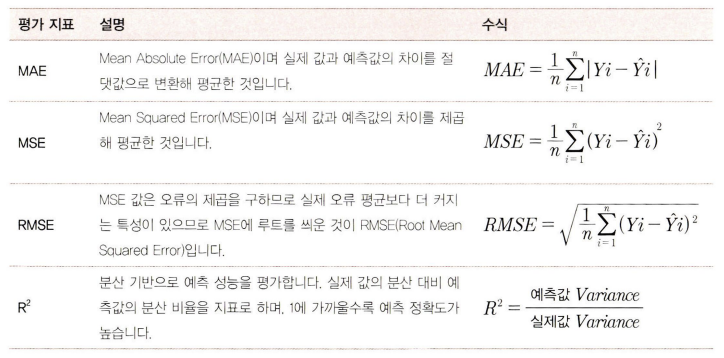

이 밖에 ... MSE, MSLE, RMSLE

각 평가 방법에 대한 사이킷런의 API 및 cross_val_score, GridSearchCV에서 평가 시 사용되는 scoring 파라미터의 적용 값

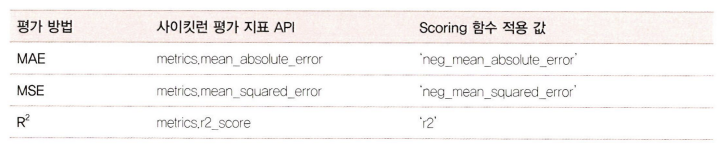

유의점
- Scoring 함수에 회귀 평가 지표 적용할 때 neg_mean_absolute_error 적용해서 음수값 반환하기
  - 사이킷런의 Scoring 함수가 score값이 클수록 좋은 평가 결과로 자동 평가하니깐

LinearRegression을 이용해 보스턴 주택 가격 회귀 구현
----------------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

In [ ]:
bostonDF.info()

In [ ]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4X2의 ax를 가짐
fig,axs=plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features=['RM','ZN', 'INDUS','NOX', 'AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
  row =int(i/4)
  col=i%4
  # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

- RM, LSTAT의 PRICE 영향도가 가장 두드러지게 나타남
- RM : 양 방향의 선형성(Positive Linearity)가 가장 큼
- LSTAT : 음 방향의 선형성이 가장 큼


In [ ]:
#회귀 모델 만들기
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis =1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형 회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print('MSE : {0:.3f}, RMSE :{1:.3F}'.format(mse,rmse))
print('Varance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

In [ ]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

In [ ]:
# 피처별 회귀 계수 값으로 다시 매핑 + 높은 값 순으로 출력하기

# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1), index=X_data.columns)
coeff.sort_values(ascending=False)

- RM이 양의 값으로 회귀 계수가 가장 큼
- NOX 피처의 회귀 계수 - 값이 너무 커 보임

In [ ]:
# 5개의 폴드 세트에서 cross_val_score()를 이용해 교차 검증으로 MSE, RMSE 추정하기

from sklearn.model_selection import cross_val_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr=LinearRegression()

#cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores=cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores) # -1을 곱함에 유의 
avg_rmse=np.mean(rmse_scores)

#cross_val_score(scoring="net_mean_squared_error")로 변환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores:',np.round(neg_mse_scores,2))
print('5 folds의 개별 RMSE scores:',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}',format(avg_rmse))